In [1]:
%%writefile /kaggle/working/requirements.txt
# ---------- Core ----------
numpy==1.26.4
pandas==2.2.2
scikit-learn==1.5.2
scipy==1.13.1

# ---------- Deep Learning ----------
torch==2.3.1
torchvision==0.18.1
sentencepiece==0.2.0

# ---------- Data Handling / NLP ----------
datasets==2.21.0
evaluate==0.4.4
pyarrow==18.0.0

# ---------- Visualization ----------
matplotlib==3.8.4
tqdm==4.67.1

# ---------- Metrics ----------
sacrebleu==2.4.2
rouge-score==0.1.2

# ---------- Misc ----------
fsspec==2024.6.1


Overwriting /kaggle/working/requirements.txt


In [ ]:
!pip install -r /kaggle/working/requirements.txt --upgrade --force-reinstall

In [3]:
# ---------------------------------------- PHASE 1 SETUP & PLANNING -----------------------------------------------

In [4]:
import pandas as pd

data_path = "/kaggle/input/empathetic-dialogues-facebook-ai/emotion-emotion_69k.csv"
df = pd.read_csv(data_path)
df.head()

,Unnamed: 0,Situation,emotion,empathetic_dialogues,labels,Unnamed: 5,Unnamed: 6
0,0,I remember going to the fireworks with my best...,sentimental,Customer :I remember going to see the firework...,"Was this a friend you were in love with, or ju...",NaN,NaN
1,1,I remember going to the fireworks with my best...,sentimental,Customer :This was a best friend. I miss her.\...,Where has she gone?,NaN,NaN
2,2,I remember going to the fireworks with my best...,sentimental,Customer :We no longer talk.\nAgent :,Oh was this something that happened because of...,NaN,NaN
3,3,I remember going to the fireworks with my best...,sentimental,Customer :Was this a friend you were in love w...,This was a best friend. I miss her.,NaN,NaN
4,4,I remember going to the fireworks with my best...,sentimental,Customer :Where has she gone?\nAgent :,We no longer talk.,NaN,NaN


In [5]:
df.info()
print(df.columns)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64636 entries, 0 to 64635
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Unnamed: 0            64636 non-null  int64 
 1   Situation             64636 non-null  object
 2   emotion               64632 non-null  object
 3   empathetic_dialogues  64636 non-null  object
 4   labels                64636 non-null  object
 5   Unnamed: 5            113 non-null    object
 6   Unnamed: 6            5 non-null      object
dtypes: int64(1), object(6)
memory usage: 3.5+ MB
Index(['Unnamed: 0', 'Situation', 'emotion', 'empathetic_dialogues', 'labels',
       'Unnamed: 5', 'Unnamed: 6'],
      dtype='object')


In [6]:
# Drop irrelevant columns
df = df.drop(columns=["Unnamed: 0", "Unnamed: 5", "Unnamed: 6"])
df.head()


,Situation,emotion,empathetic_dialogues,labels
0,I remember going to the fireworks with my best...,sentimental,Customer :I remember going to see the firework...,"Was this a friend you were in love with, or ju..."
1,I remember going to the fireworks with my best...,sentimental,Customer :This was a best friend. I miss her.\...,Where has she gone?
2,I remember going to the fireworks with my best...,sentimental,Customer :We no longer talk.\nAgent :,Oh was this something that happened because of...
3,I remember going to the fireworks with my best...,sentimental,Customer :Was this a friend you were in love w...,This was a best friend. I miss her.
4,I remember going to the fireworks with my best...,sentimental,Customer :Where has she gone?\nAgent :,We no longer talk.


In [7]:
print("Total samples:", len(df))
print("Unique emotions:", df['emotion'].nunique())
print("Missing emotions:", df['emotion'].isna().sum())
print("\nEmotion distribution:")
print(df['emotion'].value_counts().head(42))


Total samples: 64636
Unique emotions: 43
Missing emotions: 4

Emotion distribution:
emotion
surprised                                                                                                                                                                                         3295
excited                                                                                                                                                                                           2465
angry                                                                                                                                                                                             2296
proud                                                                                                                                                                                             2247
annoyed                                                                                                         

In [8]:
df['situation_len'] = df['Situation'].str.split().apply(len)
df['dialogue_len'] = df['empathetic_dialogues'].str.split().apply(len)
df['label_len'] = df['labels'].str.split().apply(len)

df[['situation_len','dialogue_len','label_len']].describe()


,situation_len,dialogue_len,label_len
count,64636.00000,64636.000000,64636.000000
mean,17.88248,16.770855,12.594050
std,10.15066,8.615902,8.199489
min,1.00000,1.000000,1.000000
25%,11.00000,11.000000,7.000000
50%,16.00000,15.000000,11.000000
75%,22.00000,20.000000,16.000000
max,109.00000,113.000000,110.000000


In [9]:
df = df.dropna(subset=['emotion'])
df.reset_index(drop=True, inplace=True)


In [10]:
for i in range(3):
    row = df.iloc[i]
    print(f"Emotion: {row['emotion']}")
    print(f"Situation: {row['Situation']}")
    print(f"Customer: {row['empathetic_dialogues']}")
    print(f"Agent: {row['labels']}")
    print("-"*80)


Emotion: sentimental
Situation: I remember going to the fireworks with my best friend. There was a lot of people, but it only felt like us in the world.
Customer: Customer :I remember going to see the fireworks with my best friend. It was the first time we ever spent time alone together. Although there was a lot of people, we felt like the only people in the world.
Agent :
Agent: Was this a friend you were in love with, or just a best friend?
--------------------------------------------------------------------------------
Emotion: sentimental
Situation: I remember going to the fireworks with my best friend. There was a lot of people, but it only felt like us in the world.
Customer: Customer :This was a best friend. I miss her.
Agent :
Agent: Where has she gone?
--------------------------------------------------------------------------------
Emotion: sentimental
Situation: I remember going to the fireworks with my best friend. There was a lot of people, but it only felt like us in the w

In [11]:
valid_emotions = [
    'surprised','excited','angry','proud','annoyed','sad','lonely','afraid','grateful',
    'terrified','guilty','furious','disgusted','confident','anxious','anticipating',
    'hopeful','impressed','nostalgic','disappointed','jealous','joyful','prepared',
    'content','devastated','embarrassed','sentimental','caring','trusting','ashamed',
    'apprehensive','faithful'
]

df = df[df['emotion'].isin(valid_emotions)].reset_index(drop=True)
print("Cleaned samples:", len(df))
print("Cleaned emotions:", df['emotion'].nunique())


Cleaned samples: 64591
Cleaned emotions: 32


In [12]:
# ---------------------------------------- PHASE 2 Preprocessing -----------------------------------------------

In [13]:
import re

def clean_text(text):
    # Convert to lowercase
    text = text.lower().strip()
    
    # Remove "customer :" or "agent :" prefixes (they’re redundant)
    text = re.sub(r'\bcustomer\s*:\s*', '', text)
    text = re.sub(r'\bagent\s*:\s*', '', text)
    
    # Remove multiple spaces
    text = re.sub(r'\s+', ' ', text)
    
    # Normalize punctuation spacing
    text = re.sub(r'\s([?.!,"])', r'\1', text)
    text = re.sub(r'([?.!,"])', r' \1 ', text)
    text = re.sub(r'\s+', ' ', text)
    
    return text.strip()

In [14]:
for col in ['Situation', 'empathetic_dialogues', 'labels']:
    df[col] = df[col].astype(str).apply(clean_text)

df.head(3)


,Situation,emotion,empathetic_dialogues,labels,situation_len,dialogue_len,label_len
0,i remember going to the fireworks with my best...,sentimental,i remember going to see the fireworks with my ...,"was this a friend you were in love with , or j...",25,41,14
1,i remember going to the fireworks with my best...,sentimental,this was a best friend . i miss her .,where has she gone ?,25,11,4
2,i remember going to the fireworks with my best...,sentimental,we no longer talk .,oh was this something that happened because of...,25,7,10


In [15]:
df = df.dropna(subset=['Situation', 'empathetic_dialogues', 'labels', 'emotion'])
df = df[df['Situation'].str.strip() != '']
df = df[df['labels'].str.strip() != '']
df = df[df['empathetic_dialogues'].str.strip() != '']
df.reset_index(drop=True, inplace=True)

print("Final cleaned dataset size:", len(df))


Final cleaned dataset size: 64591


In [16]:
!pip install sentencepiece --quiet
import sentencepiece as spm
import os


In [17]:
# Combine all text fields into one corpus
corpus_file = "corpus.txt"

with open(corpus_file, "w", encoding="utf-8") as f:
    for _, row in df.iterrows():
        f.write(row["Situation"] + "\n")
        f.write(row["empathetic_dialogues"] + "\n")
        f.write(row["labels"] + "\n")

In [18]:
vocab_size = 10000  # you can adjust (5k–10k range works fine)
model_prefix = "empathetic_tokenizer"

spm.SentencePieceTrainer.train(
    input=corpus_file,
    model_prefix=model_prefix,
    vocab_size=vocab_size,
    character_coverage=1.0,
    model_type="bpe",
    bos_id=1,
    eos_id=2,
    pad_id=0,
    unk_id=3
)

sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: corpus.txt
  input_format: 
  model_prefix: empathetic_tokenizer
  model_type: BPE
  vocab_size: 10000
  self_test_sample_size: 0
  character_coverage: 1
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_sentencepieces_file: 
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 3
  bos_id: 1
  eos_id: 2
  pad_id: 0
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piece: <pad>
  unk_surface:  ⁇ 
  enable_differential_privacy: 0
  diff

In [19]:
sp = spm.SentencePieceProcessor()
sp.load("empathetic_tokenizer.model")

sample = df.iloc[0]["labels"]
print("Original:", sample)
print("Tokens:", sp.encode(sample, out_type=str))
print("IDs:", sp.encode(sample, out_type=int))


Original: was this a friend you were in love with , or just a best friend ?
Tokens: ['▁was', '▁this', '▁a', '▁friend', '▁you', '▁were', '▁in', '▁love', '▁with', '▁,', '▁or', '▁just', '▁a', '▁best', '▁friend', '▁?']
IDs: [45, 169, 6, 168, 46, 243, 69, 304, 114, 41, 316, 138, 6, 436, 168, 73]


tive symbols. max_freq=21 min_freq=14
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=20 size=7620 all=29507 active=1507 piece=fred
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=20 size=7640 all=29535 active=1535 piece=ibiot
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=20 size=7660 all=29553 active=1553 piece=▁iwas
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=20 size=7680 all=29563 active=1563 piece=▁ideal
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=20 size=7700 all=29565 active=1565 piece=▁doggie
bpe_model_trainer.cc(159) LOG(INFO) Updating active symbols. max_freq=20 min_freq=14
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=20 size=7720 all=29553 active=1467 piece=▁traged
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=20 size=7740 all=29543 active=1457 piece=▁smacked
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=20 size=7760 all=29529 active=1443 piece=▁insisted
bpe_model_trainer.cc(268) LOG(INFO) Added: freq=20 size=7780 all=29511 active=1425 piece=▁sleepover
bpe_mo

In [20]:
special_tokens = {
    "pad": sp.pad_id(),
    "bos": sp.bos_id(),
    "eos": sp.eos_id(),
    "unk": sp.unk_id()
}
print(special_tokens)

{'pad': 0, 'bos': 1, 'eos': 2, 'unk': 3}


In [21]:
from sklearn.model_selection import train_test_split

# 80 / 10 / 10 split
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

print(f"Train: {len(train_df)}  Val: {len(val_df)}  Test: {len(test_df)}")

Train: 51672  Val: 6459  Test: 6460


In [22]:
import torch

def encode_and_pad(text, sp, max_len=128, add_special_tokens=True):
    ids = sp.encode(text, out_type=int)
    if add_special_tokens:
        ids = [sp.bos_id()] + ids + [sp.eos_id()]
    ids = ids[:max_len]                     # truncate
    pad_len = max_len - len(ids)
    if pad_len > 0:
        ids += [sp.pad_id()] * pad_len
    return torch.tensor(ids)


In [23]:
from torch.utils.data import Dataset

class EmpatheticDataset(Dataset):
    def __init__(self, df, sp, max_len=128):
        self.df = df
        self.sp = sp
        self.max_len = max_len

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # Construct input and target texts
        inp = f"emotion: {row['emotion']} | situation: {row['Situation']} | customer: {row['empathetic_dialogues']} agent:"
        tgt = row['labels']

        # Encode to token IDs
        input_ids = encode_and_pad(inp, self.sp, self.max_len)
        target_ids = encode_and_pad(tgt, self.sp, self.max_len)

        return {
            "input_ids": input_ids,
            "target_ids": target_ids
        }


In [24]:
from torch.utils.data import DataLoader

MAX_LEN = 128
BATCH_SIZE = 32

train_dataset = EmpatheticDataset(train_df, sp, MAX_LEN)
val_dataset   = EmpatheticDataset(val_df, sp, MAX_LEN)
test_dataset  = EmpatheticDataset(test_df, sp, MAX_LEN)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE)

batch = next(iter(train_loader))
print("input_ids:", batch["input_ids"].shape)
print("target_ids:", batch["target_ids"].shape)


input_ids: torch.Size([32, 128])
target_ids: torch.Size([32, 128])


In [25]:
sample = batch["input_ids"][0].tolist()
print(sp.decode(sample))


emotion: anticipating | situation: i am going on vacation to hawaii next week . i cant wait to go . ive already started packing | customer: that really is something to get excited about ! i've never been outside of the country , so i'm jealous of people that get the chance to . i hope you're able to get everything out of the trip that you want to agent:


In [26]:
# ---------------------------------------- PHASE 3 Transformer Implementation -----------------------------------------------

In [27]:
import torch
import torch.nn as nn
import math

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)                     # shape (1, max_len, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return x


In [28]:
def scaled_dot_product_attention(Q, K, V, mask=None):
    d_k = Q.size(-1)
    scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, float('-inf'))
    attn = torch.softmax(scores, dim=-1)
    output = torch.matmul(attn, V)
    return output, attn


In [29]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads, dropout=0.1):
        super().__init__()
        assert d_model % num_heads == 0
        self.d_k = d_model // num_heads
        self.num_heads = num_heads

        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, Q, K, V, mask=None):
        B = Q.size(0)
        # Project
        Q = self.W_q(Q).view(B, -1, self.num_heads, self.d_k).transpose(1, 2)
        K = self.W_k(K).view(B, -1, self.num_heads, self.d_k).transpose(1, 2)
        V = self.W_v(V).view(B, -1, self.num_heads, self.d_k).transpose(1, 2)
        # Attention
        x, attn = scaled_dot_product_attention(Q, K, V, mask)
        # Concatenate heads
        x = x.transpose(1, 2).contiguous().view(B, -1, self.num_heads * self.d_k)
        return self.W_o(x)


In [30]:
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff=2048, dropout=0.1):
        super().__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)
    def forward(self, x):
        return self.linear2(self.dropout(torch.relu(self.linear1(x))))


In [31]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff=2048, dropout=0.1):
        super().__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads, dropout)
        self.ff = FeedForward(d_model, d_ff, dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        attn_out = self.self_attn(x, x, x, mask)
        x = self.norm1(x + self.dropout(attn_out))
        ff_out = self.ff(x)
        x = self.norm2(x + self.dropout(ff_out))
        return x


In [32]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff=2048, dropout=0.1):
        super().__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads, dropout)
        self.cross_attn = MultiHeadAttention(d_model, num_heads, dropout)
        self.ff = FeedForward(d_model, d_ff, dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, enc_out, src_mask=None, tgt_mask=None):
        x2 = self.self_attn(x, x, x, tgt_mask)
        x = self.norm1(x + self.dropout(x2))
        x2 = self.cross_attn(x, enc_out, enc_out, src_mask)
        x = self.norm2(x + self.dropout(x2))
        x2 = self.ff(x)
        x = self.norm3(x + self.dropout(x2))
        return x


In [33]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, d_model, num_layers, num_heads, d_ff, dropout):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, d_model)
        self.pos_enc = PositionalEncoding(d_model)
        self.layers = nn.ModuleList([EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        self.dropout = nn.Dropout(dropout)

    def forward(self, src, mask=None):
        x = self.embed(src) * math.sqrt(self.embed.embedding_dim)
        x = self.pos_enc(self.dropout(x))
        for layer in self.layers:
            x = layer(x, mask)
        return x

class Decoder(nn.Module):
    def __init__(self, vocab_size, d_model, num_layers, num_heads, d_ff, dropout):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, d_model)
        self.pos_enc = PositionalEncoding(d_model)
        self.layers = nn.ModuleList([DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        self.dropout = nn.Dropout(dropout)
        self.fc_out = nn.Linear(d_model, vocab_size)

    def forward(self, tgt, enc_out, src_mask=None, tgt_mask=None):
        x = self.embed(tgt) * math.sqrt(self.embed.embedding_dim)
        x = self.pos_enc(self.dropout(x))
        for layer in self.layers:
            x = layer(x, enc_out, src_mask, tgt_mask)
        return self.fc_out(x)


In [34]:
class Transformer(nn.Module):
    def __init__(self, vocab_size, d_model=256, num_layers=2, num_heads=2, d_ff=256, dropout=0.1):
        super().__init__()
        self.encoder = Encoder(vocab_size, d_model, num_layers, num_heads, d_ff, dropout)
        self.decoder = Decoder(vocab_size, d_model, num_layers, num_heads, d_ff, dropout)

    def forward(self, src, tgt, src_mask=None, tgt_mask=None):
        enc_out = self.encoder(src, src_mask)
        output = self.decoder(tgt, enc_out, src_mask, tgt_mask)
        return output


In [35]:
VOCAB_SIZE = 10000
model = Transformer(VOCAB_SIZE)

src = torch.randint(0, VOCAB_SIZE, (2, 128))  # batch=2, seq_len=128
tgt = torch.randint(0, VOCAB_SIZE, (2, 128))

out = model(src, tgt)
print(out.shape)  # Expected: (2, 128, VOCAB_SIZE)


torch.Size([2, 128, 10000])


In [36]:
def create_padding_mask(seq, pad_token_id=0):
    # seq shape: (batch_size, seq_len)
    mask = (seq != pad_token_id).unsqueeze(1).unsqueeze(2)
    # shape: (batch_size, 1, 1, seq_len)
    return mask  # True for non-pad, False for pad


In [37]:
def create_causal_mask(size):
    # Create an upper-triangular matrix of 1s, with zeros on diagonal and below
    mask = torch.tril(torch.ones((size, size))).unsqueeze(0).unsqueeze(1)
    # shape: (1, 1, seq_len, seq_len)
    return mask


In [38]:
def create_masks(src, tgt, pad_token_id=0):
    src_mask = create_padding_mask(src, pad_token_id)
    tgt_padding_mask = create_padding_mask(tgt, pad_token_id)
    tgt_len = tgt.size(1)
    causal_mask = create_causal_mask(tgt_len).to(tgt.device)
    tgt_mask = tgt_padding_mask & causal_mask.bool()
    return src_mask, tgt_mask


In [39]:
import torch.nn.functional as F
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
VOCAB_SIZE = 10000

model = Transformer(VOCAB_SIZE).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4, betas=(0.9, 0.98))
criterion = nn.CrossEntropyLoss(ignore_index=0)  # ignore <pad> tokens


In [40]:
# !pip install --upgrade --force-reinstall torch==2.3.1+cu121 torchvision==0.18.1+cu121 torchaudio==2.3.1 --extra-index-url https://download.pytorch.org/whl/cu121


In [41]:
EPOCHS = 5

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for batch in train_loader:
        src = batch["input_ids"].to(device)
        tgt = batch["target_ids"].to(device)

        # Shift target for teacher forcing
        tgt_input = tgt[:, :-1]
        tgt_output = tgt[:, 1:]

        src_mask, tgt_mask = create_masks(src, tgt_input)

        # Forward pass
        preds = model(src, tgt_input, src_mask, tgt_mask)

        # Reshape for loss calculation
        preds = preds.reshape(-1, preds.size(-1))
        tgt_output = tgt_output.reshape(-1)

        loss = criterion(preds, tgt_output)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1} | Training Loss: {avg_loss:.4f}")

Epoch 1 | Training Loss: 5.1379
Epoch 2 | Training Loss: 4.4906
Epoch 3 | Training Loss: 4.3298
Epoch 4 | Training Loss: 4.2309
Epoch 5 | Training Loss: 4.1580


In [42]:
# Save after training
torch.save(model.state_dict(), "transformer_empathetic.pt")

In [43]:
# ---------------------------------------- PHASE 4 Evaluation -----------------------------------------------

In [45]:
import torch
import sentencepiece as spm

# Load tokenizer
sp = spm.SentencePieceProcessor()
sp.load("empathetic_tokenizer.model")

# Load model checkpoint (if saved)
model.load_state_dict(torch.load("transformer_empathetic.pt", map_location="cuda"))
model.eval()


Transformer(
  (encoder): Encoder(
    (embed): Embedding(10000, 256)
    (pos_enc): PositionalEncoding()
    (layers): ModuleList(
      (0-1): 2 x EncoderLayer(
        (self_attn): MultiHeadAttention(
          (W_q): Linear(in_features=256, out_features=256, bias=True)
          (W_k): Linear(in_features=256, out_features=256, bias=True)
          (W_v): Linear(in_features=256, out_features=256, bias=True)
          (W_o): Linear(in_features=256, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): FeedForward(
          (linear1): Linear(in_features=256, out_features=256, bias=True)
          (linear2): Linear(in_features=256, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (dropout):

In [46]:
def decode_tokens(ids, sp):
    tokens = [t for t in ids if t not in [sp.pad_id(), sp.bos_id(), sp.eos_id()]]
    return sp.decode(tokens)


In [47]:
def greedy_decode(model, src, sp, max_len=50, device="cuda"):
    model.eval()
    src = src.unsqueeze(0).to(device)  # add batch dimension
    src_mask = create_padding_mask(src)

    # Encoder output
    enc_out = model.encoder(src, src_mask)

    # Start token
    tgt = torch.tensor([[sp.bos_id()]], device=device)

    for _ in range(max_len):
        tgt_mask = create_causal_mask(tgt.size(1)).to(device)
        out = model.decoder(tgt, enc_out, src_mask, tgt_mask)
        next_token = out[:, -1, :].argmax(-1).unsqueeze(1)
        tgt = torch.cat([tgt, next_token], dim=1)
        if next_token.item() == sp.eos_id():
            break

    return decode_tokens(tgt[0].tolist(), sp)


In [48]:
for i in range(3):
    row = test_df.iloc[i]
    inp = f"Emotion: {row['emotion']} | Situation: {row['Situation']} | Customer: {row['empathetic_dialogues']} Agent:"
    encoded = encode_and_pad(inp, sp, max_len=128)
    pred = greedy_decode(model, encoded, sp)
    print(f"\nEmotion: {row['emotion']}")
    print(f"Ground Truth: {row['labels']}")
    print(f"Predicted: {pred}")



Emotion: sentimental
Ground Truth: well have you been living a happy life ? she would probably be happy about that .
Predicted: i bet you were able to get it .

Emotion: embarrassed
Ground Truth: ah man ! you shouldn't feel bad about tripping . why do you feel bad about it ?
Predicted: i am sorry to hear that . i hope you feel like it .

Emotion: caring
Ground Truth: it is , and yeah until they are over the age of you go go every other month crazy poor babies ! !
Predicted: i am so sorry to hear that . i am so sorry to hear that .


In [ ]:
!pip install pyarrow datasets evaluate --upgrade --force-reinstall --no-cache-dir

In [49]:
import evaluate

bleu = evaluate.load("bleu")
rouge = evaluate.load("rouge")
chrf = evaluate.load("chrf")

2025-10-17 17:15:33.557325: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760721333.587601     193 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760721333.596099     193 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [50]:
from tqdm import tqdm

references, predictions = [], []

for i in tqdm(range(500)):
    row = test_df.iloc[i]
    inp = f"Emotion: {row['emotion']} | Situation: {row['Situation']} | Customer: {row['empathetic_dialogues']} Agent:"
    src = encode_and_pad(inp, sp, max_len=128)
    pred = greedy_decode(model, src, sp)
    references.append([row["labels"]])
    predictions.append(pred)


100%|██████████| 500/500 [00:26<00:00, 18.72it/s]


In [51]:
bleu_score = bleu.compute(predictions=predictions, references=references)
rouge_score = rouge.compute(predictions=predictions, references=references)
chrf_score = chrf.compute(predictions=predictions, references=references)

print(f"BLEU: {bleu_score['bleu']:.4f}")
print(f"ROUGE-L: {rouge_score['rougeL']:.4f}")
print(f"chrF: {chrf_score['score']:.4f}")


BLEU: 0.0099
ROUGE-L: 0.1329
chrF: 12.1099


In [52]:
import math

model.eval()
test_loss = 0
with torch.no_grad():
    for batch in test_loader:
        src = batch["input_ids"].to(device)
        tgt = batch["target_ids"].to(device)
        tgt_input = tgt[:, :-1]
        tgt_output = tgt[:, 1:]
        src_mask, tgt_mask = create_masks(src, tgt_input)

        preds = model(src, tgt_input, src_mask, tgt_mask)
        preds = preds.reshape(-1, preds.size(-1))
        tgt_output = tgt_output.reshape(-1)
        loss = criterion(preds, tgt_output)
        test_loss += loss.item()

test_loss /= len(test_loader)
perplexity = math.exp(test_loss)
print(f"Perplexity: {perplexity:.2f}")


Perplexity: 63.76


In [53]:
torch.save(model.state_dict(), "empathetic_transformer_final.pt")

results = {
    "BLEU": bleu_score["bleu"],
    "ROUGE-L": rouge_score["rougeL"],
    "chrF": chrf_score["score"],
    "Perplexity": perplexity
}
print(results)


{'BLEU': 0.009887302325262626, 'ROUGE-L': 0.13292753863234585, 'chrF': 12.10994031037383, 'Perplexity': 63.76103410034075}


✅ New best model saved with BLEU = 0.0131
Epoch 1/5 | Loss: 4.8674 | BLEU: 0.0131 | ROUGE-L: 0.1395 | chrF: 11.4569


Epoch 2/5 | Loss: 4.8236 | BLEU: 0.0125 | ROUGE-L: 0.1351 | chrF: 12.4606


Epoch 3/5 | Loss: 4.8019 | BLEU: 0.0127 | ROUGE-L: 0.1362 | chrF: 12.4880


Epoch 4/5 | Loss: 4.7894 | BLEU: 0.0127 | ROUGE-L: 0.1350 | chrF: 12.2998


Epoch 5/5 | Loss: 4.7811 | BLEU: 0.0120 | ROUGE-L: 0.1380 | chrF: 12.7299

Sample predictions:
Input: i'm proud of my wife and children for always being there for me .
Predicted: i am so happy for you !
Reference: 10 and 13
------------------------------------------------------------
Input: tomorrow is my 14th year anniversary married to my wonderful husband . i can't believe it was that long ago . what a wonderful day .
Predicted: i am sure you will . it is a good for you .
Reference: that's sounds nice and romantic
------------------------------------------------------------
Input: even though i've had lots of dating success i still get pretty stoked when i get a text back from a really attractive girl i didn't expect to hear back from . . . i just do a good job hiding it
Predicted: i am going to the same . i am so i am so happy for the same . i am so i am so i am so i am so i am so i am so i am so i am so i am so i am so i am
Reference: because girls find it more attractive . in my 

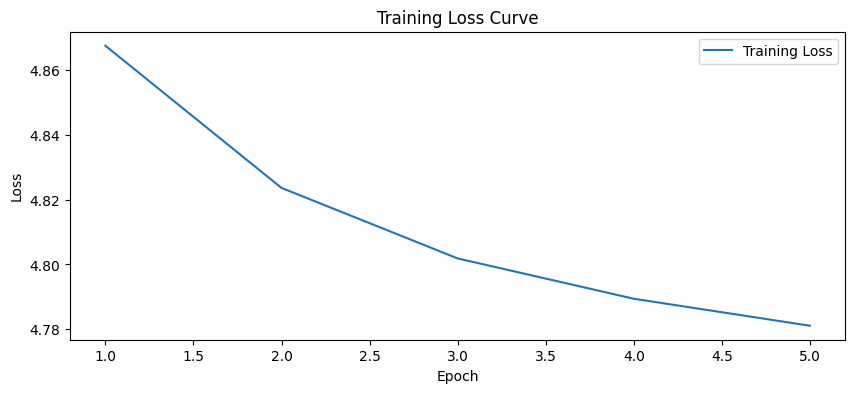

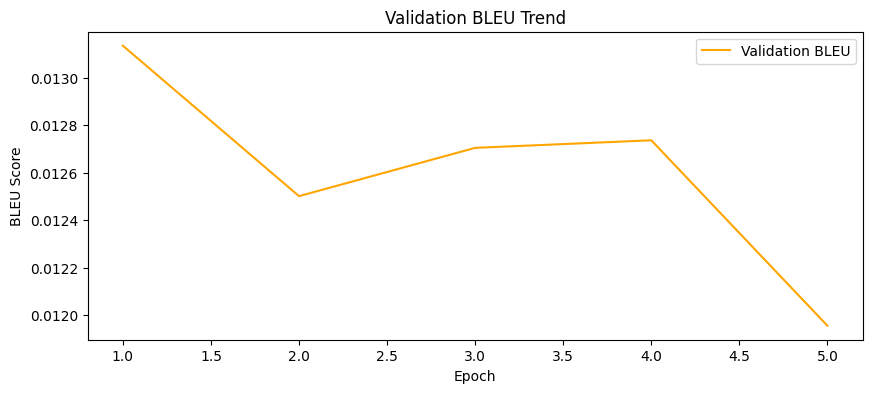

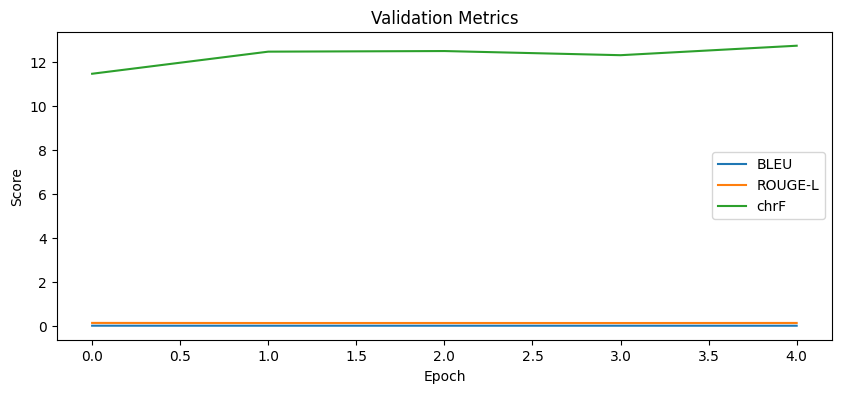

In [59]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm
import matplotlib.pyplot as plt

# Loss with label smoothing
criterion = nn.CrossEntropyLoss(label_smoothing=0.1, ignore_index=sp.pad_id())

# Scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

# GradScaler for mixed precision
scaler = torch.cuda.amp.GradScaler()

# Metric tracking
train_losses, val_bleus, val_rouges, val_chrfs = [], [], [], []

EPOCHS = 5
best_bleu = 0.0

# =======================
# 🚀 Training Loop
# =======================
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0.0

    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}", leave=False)
    for batch in progress_bar:
        src = batch["input_ids"].to(device)
        tgt = batch["target_ids"].to(device)
        tgt_input = tgt[:, :-1]
        tgt_output = tgt[:, 1:]
        src_mask, tgt_mask = create_masks(src, tgt_input)

        optimizer.zero_grad()

        # 🧠 Mixed precision forward + backward
        with torch.cuda.amp.autocast():
            preds = model(src, tgt_input, src_mask, tgt_mask)
            preds = preds.reshape(-1, preds.size(-1))
            tgt_output = tgt_output.reshape(-1)
            loss = criterion(preds, tgt_output)

        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()
        progress_bar.set_postfix({"Batch Loss": f"{loss.item():.4f}"})

    avg_loss = total_loss / len(train_loader)
    scheduler.step(avg_loss)
    train_losses.append(avg_loss)

    # =======================
    # 🧪 Validation
    # =======================
    model.eval()
    refs, preds_text = [], []

    for i in range(len(val_df)):
        row = val_df.iloc[i]
        inp = f"Emotion: {row['emotion']} | Situation: {row['Situation']} | Customer: {row['empathetic_dialogues']} Agent:"
        encoded = encode_and_pad(inp, sp)
        pred = greedy_decode(model, encoded, sp)
        preds_text.append(pred)
        refs.append([row['labels']])

    val_bleu = bleu.compute(predictions=preds_text, references=refs)["bleu"]
    val_rouge = rouge.compute(predictions=preds_text, references=refs)["rougeL"]
    val_chrf = chrf.compute(predictions=preds_text, references=refs)["score"]

    val_bleus.append(val_bleu)
    val_rouges.append(val_rouge)
    val_chrfs.append(val_chrf)

    if val_bleu > best_bleu:
        best_bleu = val_bleu
        torch.save(model.state_dict(), "best_transformer.pt")
        print(f"✅ New best model saved with BLEU = {best_bleu:.4f}")

    print(f"Epoch {epoch+1}/{EPOCHS} | Loss: {avg_loss:.4f} | BLEU: {val_bleu:.4f} | ROUGE-L: {val_rouge:.4f} | chrF: {val_chrf:.4f}")

    # 🔍 Show predictions every 5 epochs
    if (epoch + 1) % 5 == 0:
        print("\nSample predictions:")
        for j in range(3):
            row = val_df.iloc[j]
            inp = f"Emotion: {row['emotion']} | Situation: {row['Situation']} | Customer: {row['empathetic_dialogues']} Agent:"
            encoded = encode_and_pad(inp, sp)
            pred = greedy_decode(model, encoded, sp)
            print(f"Input: {row['Situation']}")
            print(f"Predicted: {pred}")
            print(f"Reference: {row['labels']}")
            print("-" * 60)

# =======================
# 📈 Plot Results
# =======================
plt.figure(figsize=(10,4))
plt.plot(range(1, len(train_losses)+1), train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.show()

plt.figure(figsize=(10,4))
plt.plot(range(1, len(val_bleus)+1), val_bleus, label='Validation BLEU', color='orange')
plt.xlabel('Epoch')
plt.ylabel('BLEU Score')
plt.title('Validation BLEU Trend')
plt.legend()
plt.show()

plt.figure(figsize=(10,4))
plt.plot(val_bleus, label='BLEU')
plt.plot(val_rouges, label='ROUGE-L')
plt.plot(val_chrfs, label='chrF')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('Validation Metrics')
plt.legend()
plt.show()

In [58]:
# =======================
# 🧠 Final Evaluation Phase
# =======================
import math
import torch
from tqdm.auto import tqdm # Ensure tqdm is imported, using tqdm.auto for environment compatibility

# Load best model checkpoint
# Assuming 'device' is already defined (e.g., 'cuda' or 'cpu')
model.load_state_dict(torch.load("empathetic_transformer_final.pt", map_location=device))
model.eval()

refs, preds_text = [], []

# Run on the full validation set (or test_df if available)
# 🔄 Integrated tqdm for the Generation Phase
print("Generating predictions for validation set...")
for i in tqdm(range(len(val_df)), desc="Generating Responses"):
    row = val_df.iloc[i]
    # NOTE: Assuming 'empathetic_dialogues' is the source text in your dataset
    inp = f"Emotion: {row['emotion']} | Situation: {row['Situation']} | Customer: {row['empathetic_dialogues']} Agent:"
    
    # NOTE: Assuming encode_and_pad and greedy_decode are defined elsewhere
    encoded = encode_and_pad(inp, sp)
    pred = greedy_decode(model, encoded, sp)

    preds_text.append(pred)
    # NOTE: Assuming 'labels' is a string; refs needs to be a list of lists for metrics
    refs.append([row['labels']]) 

# 🧮 Compute metrics
# NOTE: Assuming bleu, rouge, and chrf evaluators are loaded (e.g., evaluate.load("bleu"))
print("Calculating standard metrics (BLEU, ROUGE, chrF)...")
bleu_score = bleu.compute(predictions=preds_text, references=refs)
rouge_score = rouge.compute(predictions=preds_text, references=refs)
chrf_score = chrf.compute(predictions=preds_text, references=refs)

# 📊 Compute Perplexity
total_loss = 0.0
count = 0
# NOTE: Assuming 'criterion' (loss function) and 'val_loader' are defined elsewhere
print("Calculating Perplexity...")
with torch.no_grad():
    # 🔄 Integrated tqdm for the Perplexity Calculation Phase
    for batch in tqdm(val_loader, desc="Calculating Loss (Perplexity)"):
        src = batch["input_ids"].to(device)
        tgt = batch["target_ids"].to(device)
        tgt_input = tgt[:, :-1]
        tgt_output = tgt[:, 1:]
        
        # NOTE: Assuming create_masks is defined elsewhere
        src_mask, tgt_mask = create_masks(src, tgt_input)

        preds = model(src, tgt_input, src_mask, tgt_mask)
        preds = preds.reshape(-1, preds.size(-1))
        tgt_output = tgt_output.reshape(-1)

        loss = criterion(preds, tgt_output)
        total_loss += loss.item()
        count += 1

perplexity = math.exp(total_loss / count)

# 🏁 Print Final Metrics
results = {
    "BLEU": bleu_score["bleu"],
    "ROUGE-L": rouge_score["rougeL"],
    "chrF": chrf_score["score"],
    "Perplexity": perplexity
}
print("\n========== 🧪 FINAL EVALUATION RESULTS ==========")
for k, v in results.items():
    print(f"{k:10s}: {v:.4f}")

# =======================
# 💬 Sample Predictions
# =======================
print("\n========== 💬 SAMPLE PREDICTIONS ==========")
for i in range(5):
    # NOTE: Assuming val_df is a pandas DataFrame
    row = val_df.sample(1).iloc[0]
    inp = f"Emotion: {row['emotion']} | Situation: {row['Situation']} | Customer: {row['empathetic_dialogues']} Agent:"
    encoded = encode_and_pad(inp, sp)
    pred = greedy_decode(model, encoded, sp)

    print(f"\n🧩 Emotion: {row['emotion']}")
    print(f"🗨️  Situation: {row['Situation']}")
    print(f"👤 Customer: {row['empathetic_dialogues']}")
    print(f"🤖 Predicted Agent: {pred}")
    print(f"🎯 Reference: {row['labels']}")
    print("-" * 80)

Generating predictions for validation set...


Generating Responses:   0%|          | 0/6459 [00:00<?, ?it/s]

Calculating standard metrics (BLEU, ROUGE, chrF)...
Calculating Perplexity...


Calculating Loss (Perplexity):   0%|          | 0/202 [00:00<?, ?it/s]


========== 🧪 FINAL EVALUATION RESULTS ==========
BLEU      : 0.0116
ROUGE-L   : 0.1369
chrF      : 11.9479
Perplexity: 174.5097

========== 💬 SAMPLE PREDICTIONS ==========

🧩 Emotion: prepared
🗨️  Situation: i have been training for years for the football match .
👤 Customer: football , soccer or american football
🤖 Predicted Agent: i am sure you will .
🎯 Reference: like american football . i feel really prepared that my team will beat the rivals .
--------------------------------------------------------------------------------

🧩 Emotion: joyful
🗨️  Situation: i had a baby last month , so happy .
👤 Customer: i know you are over the moon . what did you have ?
🤖 Predicted Agent: i was going to the same . i was so much . i was so happy for the same . i was so i was so happy for the same .
🎯 Reference: it was a boy , i named him after me .
--------------------------------------------------------------------------------

🧩 Emotion: terrified
🗨️  Situation: i was working on a house and a wh